In [4]:
#from v1_run_frcnn import v1Torch
#v1 = v1Torch()

In [1]:
%load_ext autoreload
%autoreload 2

import os

from torch.utils.data import DataLoader
import numpy as np
import torch
from v1.model_config import resnet50_cfg
from v1.dataset import DS2, collate_fn
from v1.transforms import get_transforms
import v1.base_utils as base_utils
from utils0 import AverageMeter
from evalutor import F1Evalutor
from model.model_frcnnfpn import fasterrcnn_resnet_fpn

log_file = open(resnet50_cfg.logs, 'w', encoding='utf-8')

__V1 full Dataset__ 

In [5]:
# use our dataset and defined transformations
dataset = DS2(data_folder = resnet50_cfg.img_dir[0],
                    dataset_list=resnet50_cfg.train_labeled_file,
                    transforms=get_transforms(True))

dataset_test = DS2(data_folder = resnet50_cfg.img_dir[0],
                    dataset_list=resnet50_cfg.val_labeled_file,
                    transforms=get_transforms(True))
# split the dataset in train and test set
#torch.manual_seed(1)
#indices = torch.randperm(len(dataset)).tolist()
#dataset = torch.utils.data.Subset(dataset, indices[:-5])
#train_dataset = torch.utils.data.Subset(dataset, indices[:-50])
#val_test = torch.utils.data.Subset(dataset, indices[-50:])


# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=base_utils.collate_fn)

val_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=base_utils.collate_fn)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fasterrcnn_resnet_fpn(resnet_name=resnet50_cfg.backbone, num_classes=6)
model = model.to(device)

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=resnet50_cfg.lr,
                      momentum=resnet50_cfg.momentum, weight_decay=resnet50_cfg.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=resnet50_cfg.lr_steps, gamma=resnet50_cfg.lr_gamma)
best_f1 = -100
start_epoch = 0

if resnet50_cfg.resume:
    checkpoints = torch.load('checkpoints/last_checkpoint.pt')
    start_epoch = checkpoints['epoch']
    model.load_state_dict(checkpoints['weights'])
    optimizer.load_state_dict(checkpoints['optimizer'])
    lr_scheduler.load_state_dict(checkpoints['lr_scheduler'])

In [8]:
from v1_run_frcnn import train_one_epoch, validation

In [9]:
for e in range(start_epoch+1, resnet50_cfg.epochs+1):

    train_one_epoch(model, data_loader, optimizer, e, log_file, device)
    lr_scheduler.step()
    val_f1 = validation(model, val_loader, e, log_file, device)
    states = {
        'epoch': e,
        'weights': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict()
    }
    torch.save(states,
               'checkpoints/last_checkpoint.pt')
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(),
                   'checkpoints/weights/best_model.pt')
    if e % resnet50_cfg.save_freq == 0:
        torch.save(model.state_dict(),
                   'checkpoints/weights/epoch_{}_f1_{:.5f}.pt'.format(e, val_f1))
log_file.close()

/home/redne/anaconda3/envs/cv/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428266983/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


[Train]Epoch: [1][20/50]	Loss_sum:  1.305022( 2.470836)	Cls:  0.197895( 1.213011)	Box:  0.019571( 0.065852)	Obj:  0.676180( 0.691537)	RPN  0.411377( 0.500436)
[Train]Epoch: [1][40/50]	Loss_sum:  1.096656( 1.953233)	Cls:  0.296891( 0.768499)	Box:  0.062034( 0.048746)	Obj:  0.431605( 0.642048)	RPN  0.306127( 0.493940)
[Validation]Epoch: [1]	Precision:0.00000	Recall:0.00000	F1-Score:0.00000
[Train]Epoch: [2][20/50]	Loss_sum:  1.563039( 1.530990)	Cls:  0.447280( 0.413599)	Box:  0.242919( 0.202001)	Obj:  0.399868( 0.410819)	RPN  0.472973( 0.504571)
[Train]Epoch: [2][40/50]	Loss_sum:  1.332642( 1.519823)	Cls:  0.507465( 0.452370)	Box:  0.275666( 0.226833)	Obj:  0.283422( 0.378222)	RPN  0.266090( 0.462399)
[Validation]Epoch: [2]	Precision:0.00000	Recall:0.00000	F1-Score:0.00000
[Train]Epoch: [3][20/50]	Loss_sum:  2.175426( 1.620048)	Cls:  0.766443( 0.532815)	Box:  0.450141( 0.291489)	Obj:  0.376454( 0.306171)	RPN  0.582388( 0.489573)
[Train]Epoch: [3][40/50]	Loss_sum:  1.591039( 1.627148)	Cls

In [10]:
# use our dataset and defined transformations
test_dataset = DS2(data_folder = resnet50_cfg.img_dir[0],
                    dataset_list=resnet50_cfg.val_labeled_file,
                    transforms=get_transforms(True))

In [11]:
# pick one image from the test set
img, _ = test_dataset[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [12]:
prediction

[{'boxes': tensor([[3.5591e+02, 3.4269e+02, 5.2071e+02, 5.3276e+02],
          [2.8596e+02, 8.8126e-01, 3.6739e+02, 7.3027e+01],
          [5.4290e+02, 1.8218e+01, 5.9838e+02, 6.5940e+01],
          [7.9376e+02, 1.4501e+01, 8.3720e+02, 5.5355e+01],
          [4.1559e+02, 1.0772e+02, 4.7010e+02, 1.7633e+02],
          [2.6973e+02, 4.7385e+02, 3.2161e+02, 5.7514e+02],
          [2.4393e+02, 2.0107e+02, 3.4612e+02, 2.4380e+02],
          [6.0837e+02, 2.3882e+02, 7.1654e+02, 3.2175e+02],
          [4.9920e+02, 3.2175e+01, 5.1382e+02, 1.1277e+02],
          [3.2668e+02, 1.1505e+02, 3.5473e+02, 1.3126e+02],
          [3.3225e+02, 1.1212e+02, 3.4918e+02, 1.3868e+02],
          [4.2226e+02, 1.9781e+02, 5.4696e+02, 2.2632e+02],
          [4.9439e+02, 3.3629e+01, 5.0717e+02, 1.1263e+02],
          [2.6423e+02, 4.5540e+02, 3.1979e+02, 5.7503e+02],
          [7.1081e+02, 0.0000e+00, 7.3341e+02, 2.2372e+01],
          [7.0940e+02, 0.0000e+00, 7.3490e+02, 2.2327e+01],
          [4.3060e+02, 2.0645e+

_https://nbviewer.jupyter.org/github/ml-mipt/ml-mipt/blob/master/week1_12_cv_intro_detection_r-cnn/week12_object_detection_practice.ipynb_

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list. The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [13]:
from PIL import Image

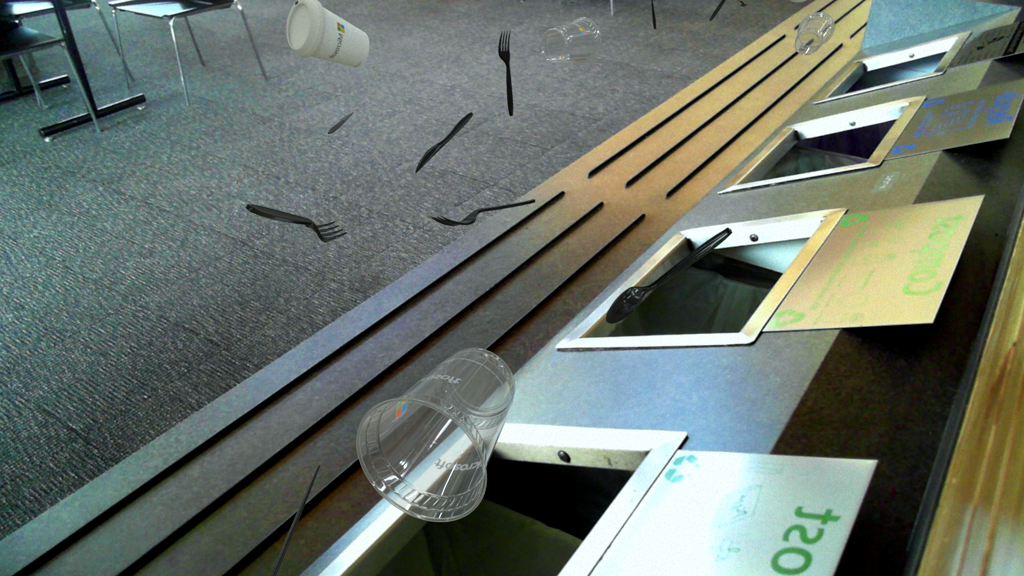

In [14]:
sample = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
sample

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in [C, H, W] format.

N persons detected:  73


IndexError: string index out of range

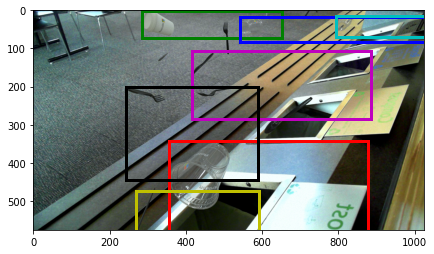

In [15]:
from matplotlib import pyplot as plt
prediction_tensor = prediction[0]['boxes'].cpu().numpy()

print('N persons detected: ', len(prediction_tensor))
plt.figure(figsize=(7,10))
plt.imshow(sample)
color_palette = 'rgbcmyk'
for i in range(len(prediction_tensor)):
    rect = prediction_tensor[i] 
    plt.gca().add_artist(
      plt.Rectangle(rect[:2], rect[2], rect[3],
                    fill=False, color=color_palette[i], linewidth=3)
      )
plt.show()

In [30]:
rect[3]

86.86873